In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import pdb
from tqdm import tqdm

import scipy.stats as stats
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from joblib import Parallel, delayed

np.random.seed(97)

In [2]:
final_design_seqs_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/"
ensemble_predictions_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/ensemble_predictions/"
kmer_k = 6

In [3]:
# NOTE: ensemble 0 is the original ensemble 3 and ensemble 1 is the original ensemble 4
ensemble_1_filtered_sequences = pd.read_parquet(os.path.join(ensemble_predictions_dir, 
                                                             "filtered_ensemble_4_predictions.parquet"))
ensemble_1_dataset_seqs = ensemble_1_filtered_sequences[ensemble_1_filtered_sequences["design_method"] == "Dataset"].reset_index(drop=True)

In [4]:
def get_all_kmers(k):
    bases = ["A", "C", "G", "T"]
    all_kmers = [""] * (len(bases)**k)

    for i in range(k):
        for j in range(int(len(bases)**i)):
            for b, base in enumerate(bases):
                for l in range(len(bases)**(k - i - 1)):
                    ind = int(l + (j*len(bases) + b)*(len(bases)**(k - i - 1)))
                    all_kmers[ind] = all_kmers[ind][:i] + base
    
    assert len(set(all_kmers)) == len(bases)**k
    
    kmer_to_ind = {}
    for i, kmer in enumerate(all_kmers):
        kmer_to_ind[kmer] = i
    
    return all_kmers, kmer_to_ind

def get_kmer_counts(seq, kmer_size, kmer_to_ind):
    assert len(seq) >= kmer_size
    kmer_counts = np.zeros(4**kmer_size)
    for i in range(len(seq) - kmer_size + 1):
        kmer_counts[kmer_to_ind[seq[i: i+kmer_size]]] += 1
    return kmer_counts

In [5]:
all_kmers, kmer_to_ind = get_all_kmers(kmer_k)

In [6]:
methods = ["coms", "dens"]
num_seqs = [None, None]
all_seqs = []
all_sources = []
for i, method in enumerate(methods):
    print(method, num_seqs[i])
    seqs = pickle.load(open(os.path.join(final_design_seqs_dir, f"{method}_final_design_v2.pkl"), "rb"))
    seqs_df = []
    kmer_features = {}
    for cell in ["jurkat", "k562", "thp1"]:
        kmer_features[cell] = seqs[cell]["kmer_features"]
        seqs[cell].pop("kmer_features")
        df = pd.DataFrame(seqs[cell])
        df["designed_for"] = cell
        
        if num_seqs[i] is not None:
            df = df.tail(num_seqs[i])
        
        seqs_df.append(df)
    
    seqs_df = pd.concat(seqs_df).reset_index(drop=True)
    all_seqs.extend(seqs_df["sequences"])
    all_sources.extend([f"{method}" for s in seqs_df["sequences"]])
    
raw_seqs = list(ensemble_1_dataset_seqs["sequence"]) + all_seqs
all_sources = ["Dataset" for s in list(ensemble_1_dataset_seqs["sequence"])] + all_sources
all_sources = np.array(all_sources)
print(len(raw_seqs))
print(len(all_sources))

coms None
dens None
32104
32104


In [7]:
raw_seqs_kmer_counts = []
for i, seq in tqdm(enumerate(raw_seqs)):
    raw_seqs_kmer_counts.append(get_kmer_counts(seq, kmer_k, kmer_to_ind))

32104it [00:04, 7275.45it/s]


In [8]:
raw_seqs_kmer_counts = np.stack(raw_seqs_kmer_counts)
print(raw_seqs_kmer_counts.shape)
pairwise_distances = pairwise_distances(raw_seqs_kmer_counts, metric="euclidean", n_jobs=-1)
pairwise_distances = pairwise_distances / (245*np.sqrt(2))
print(pairwise_distances.shape)

(32104, 4096)
(32104, 32104)


(12000,)


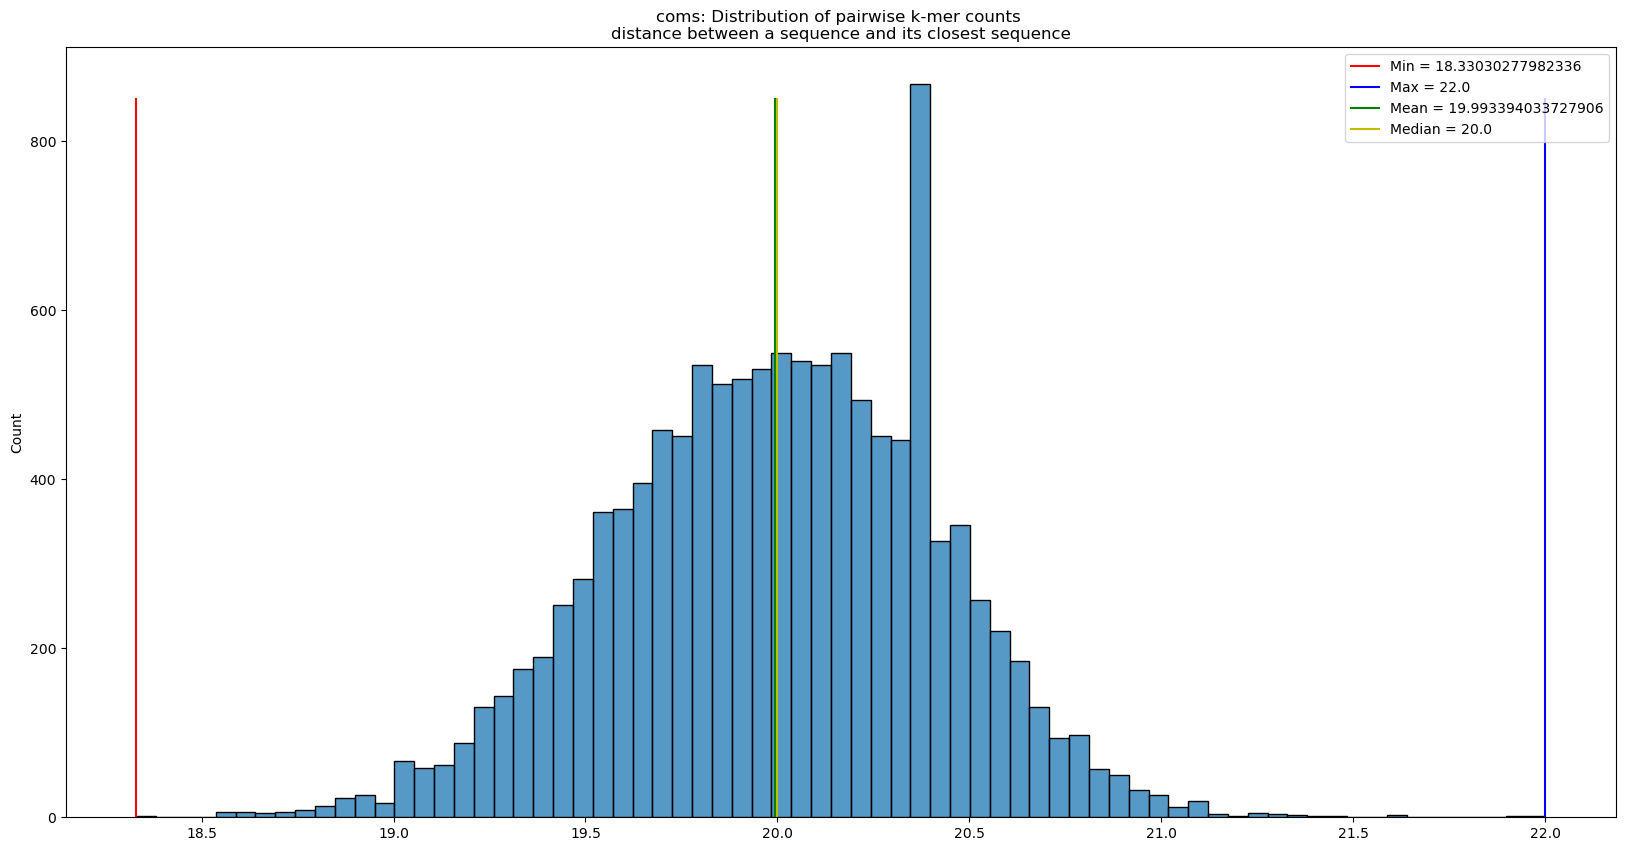

(3000,)


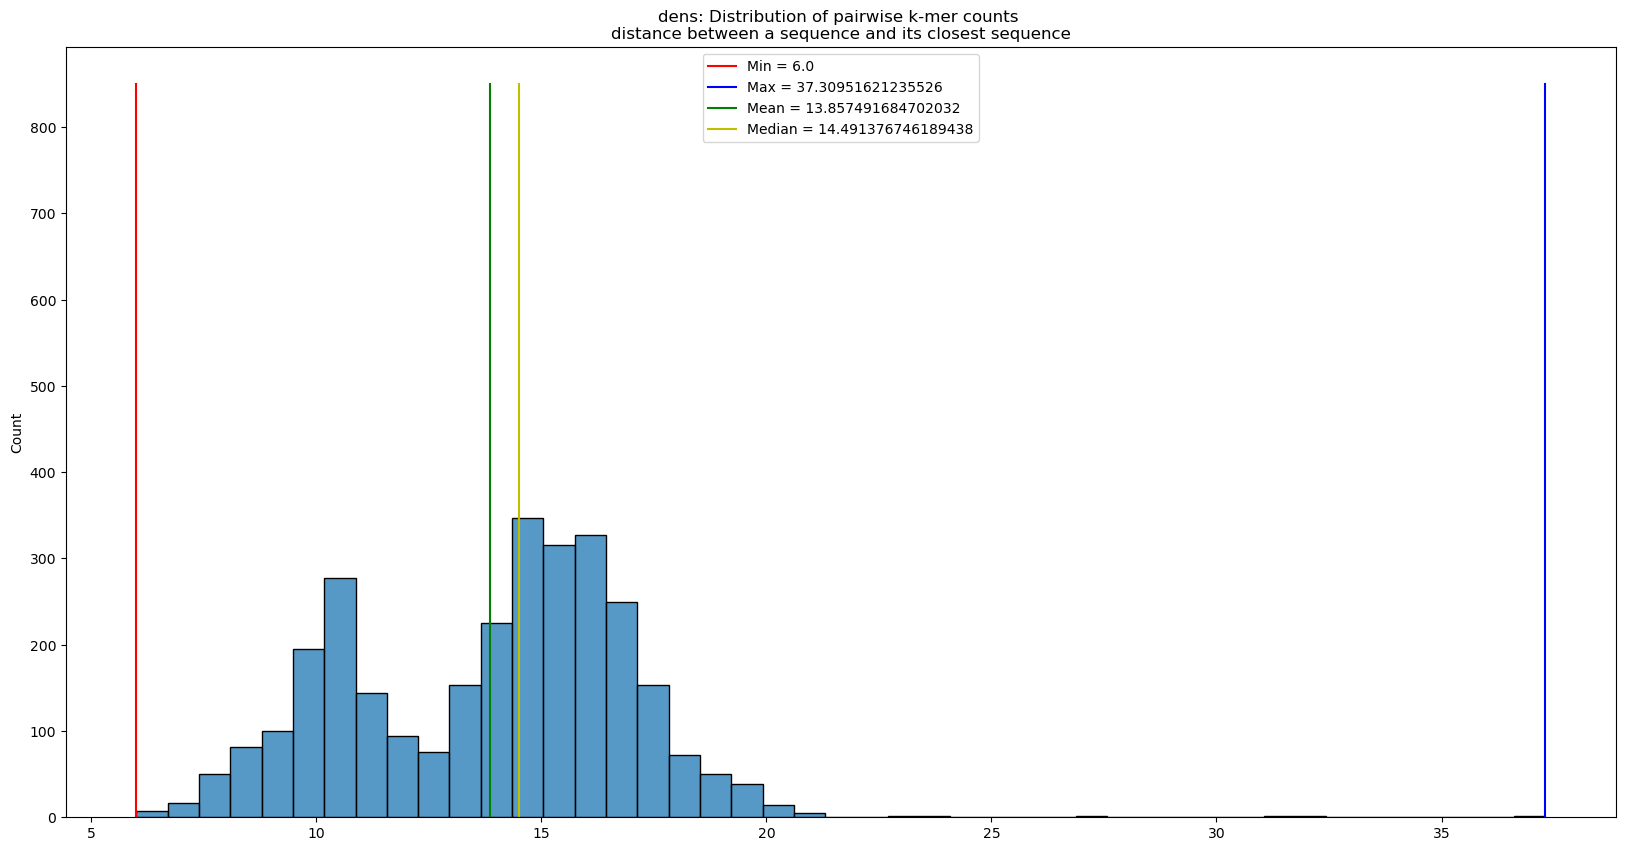

(17104,)


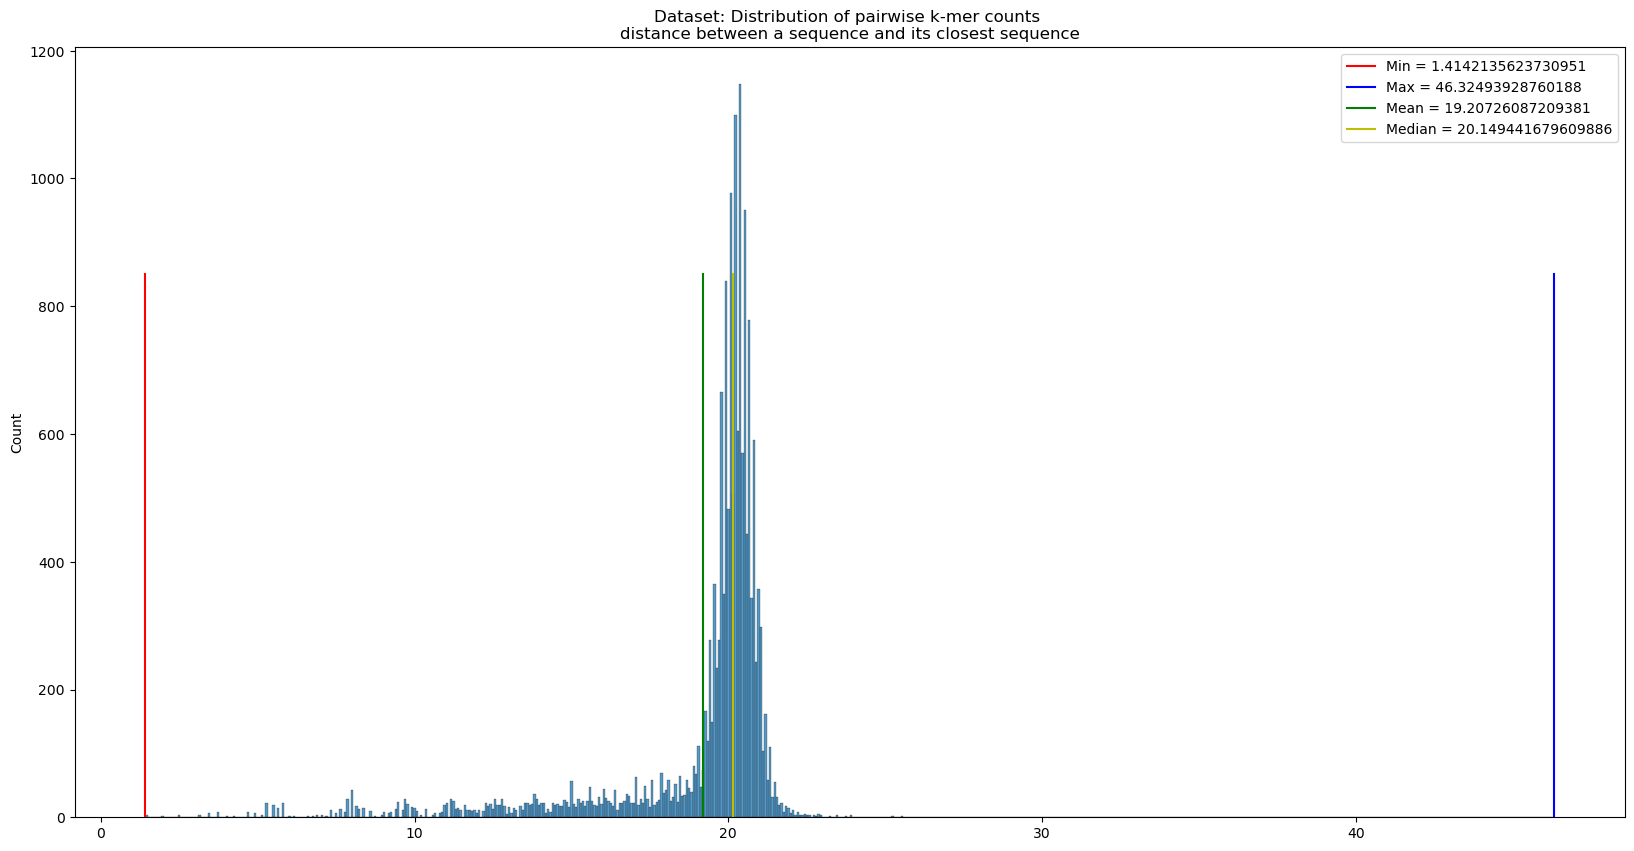

(15000,)


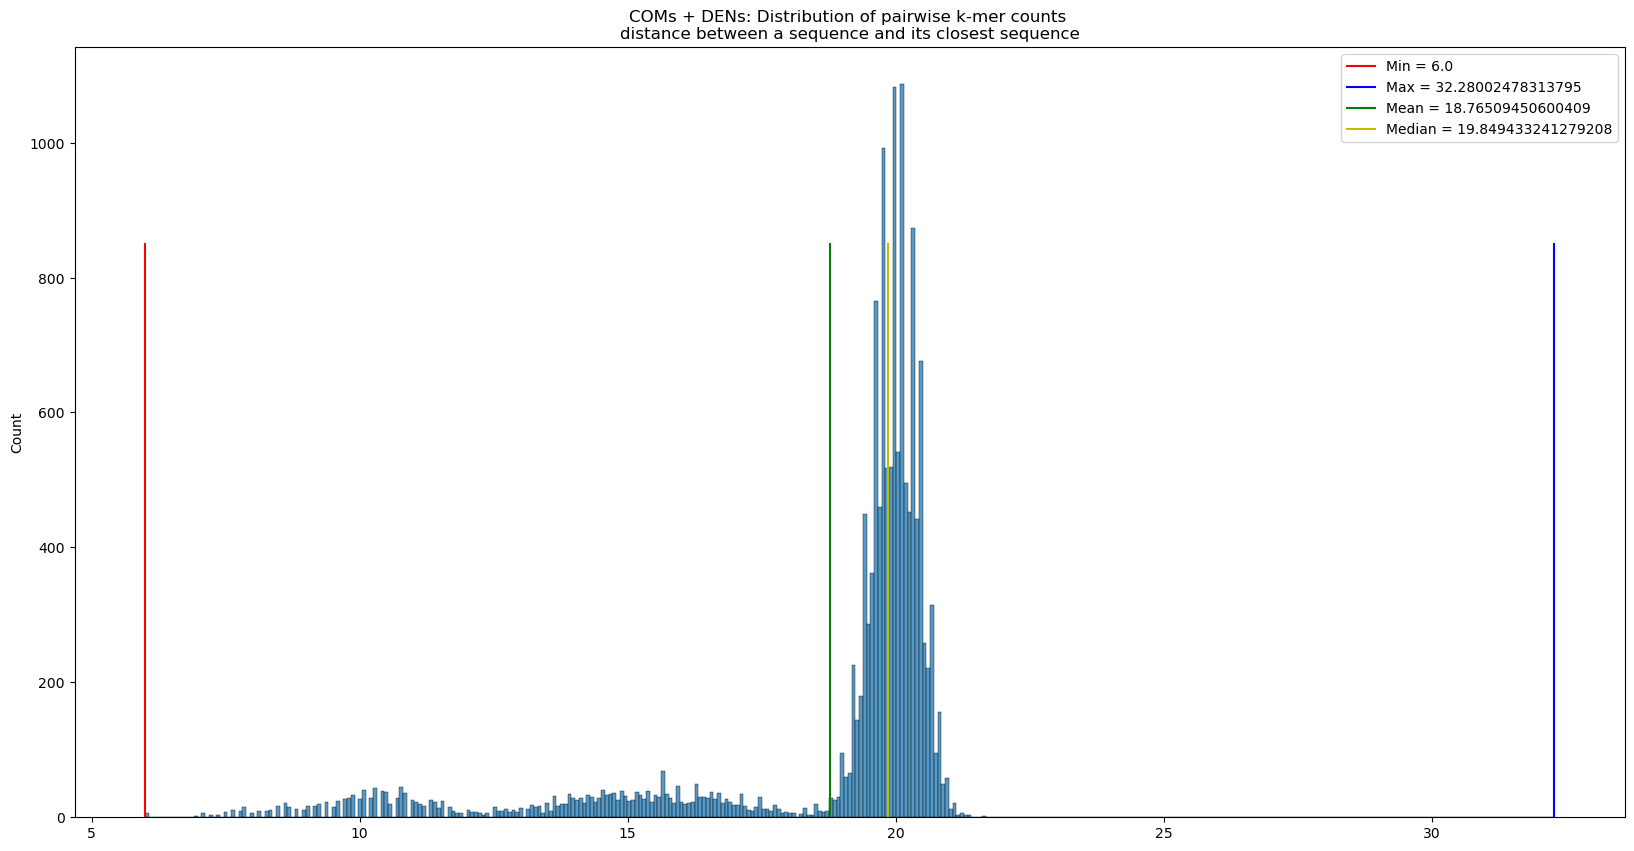

In [9]:
# get distribution of min pairwise distances for each method
for method in methods + ["Dataset", "COMs + DENs"]:
    if method == "COMs + DENs":
        seq_inds = all_sources != "Dataset"
    else:
        seq_inds = all_sources == method
    method_pairwise_dist_matrix = pairwise_distances[seq_inds][:, seq_inds]
    diag_inds = np.diag_indices_from(method_pairwise_dist_matrix)
    method_pairwise_dist_matrix[diag_inds] = np.inf
    min_dist_to_another_seq = method_pairwise_dist_matrix.min(axis=1) * (245*np.sqrt(2))
    print(min_dist_to_another_seq.shape)
    
#     triu_inds = np.triu_indices_from(method_pairwise_dist_matrix, k=-1)
#     triu_mat = method_pairwise_dist_matrix[triu_inds]
    
    plt.figure(figsize=(20, 10))
    sns.histplot(min_dist_to_another_seq)
    plt.plot([min_dist_to_another_seq.min() for i in range(10)], np.linspace(0, 850, 10), "r-", label=f"Min = {min_dist_to_another_seq.min()}")
    plt.plot([min_dist_to_another_seq.max() for i in range(10)], np.linspace(0, 850, 10), "b-", label=f"Max = {min_dist_to_another_seq.max()}")
    plt.plot([min_dist_to_another_seq.mean() for i in range(10)], np.linspace(0, 850, 10), "g-", label=f"Mean = {min_dist_to_another_seq.mean()}")
    plt.plot([np.median(min_dist_to_another_seq) for i in range(10)], np.linspace(0, 850, 10), "y-", label=f"Median = {np.median(min_dist_to_another_seq)}")
    plt.title(f"{method}: Distribution of pairwise k-mer counts \ndistance between a sequence and its closest sequence")
    plt.legend()
    plt.show()

(12000,)


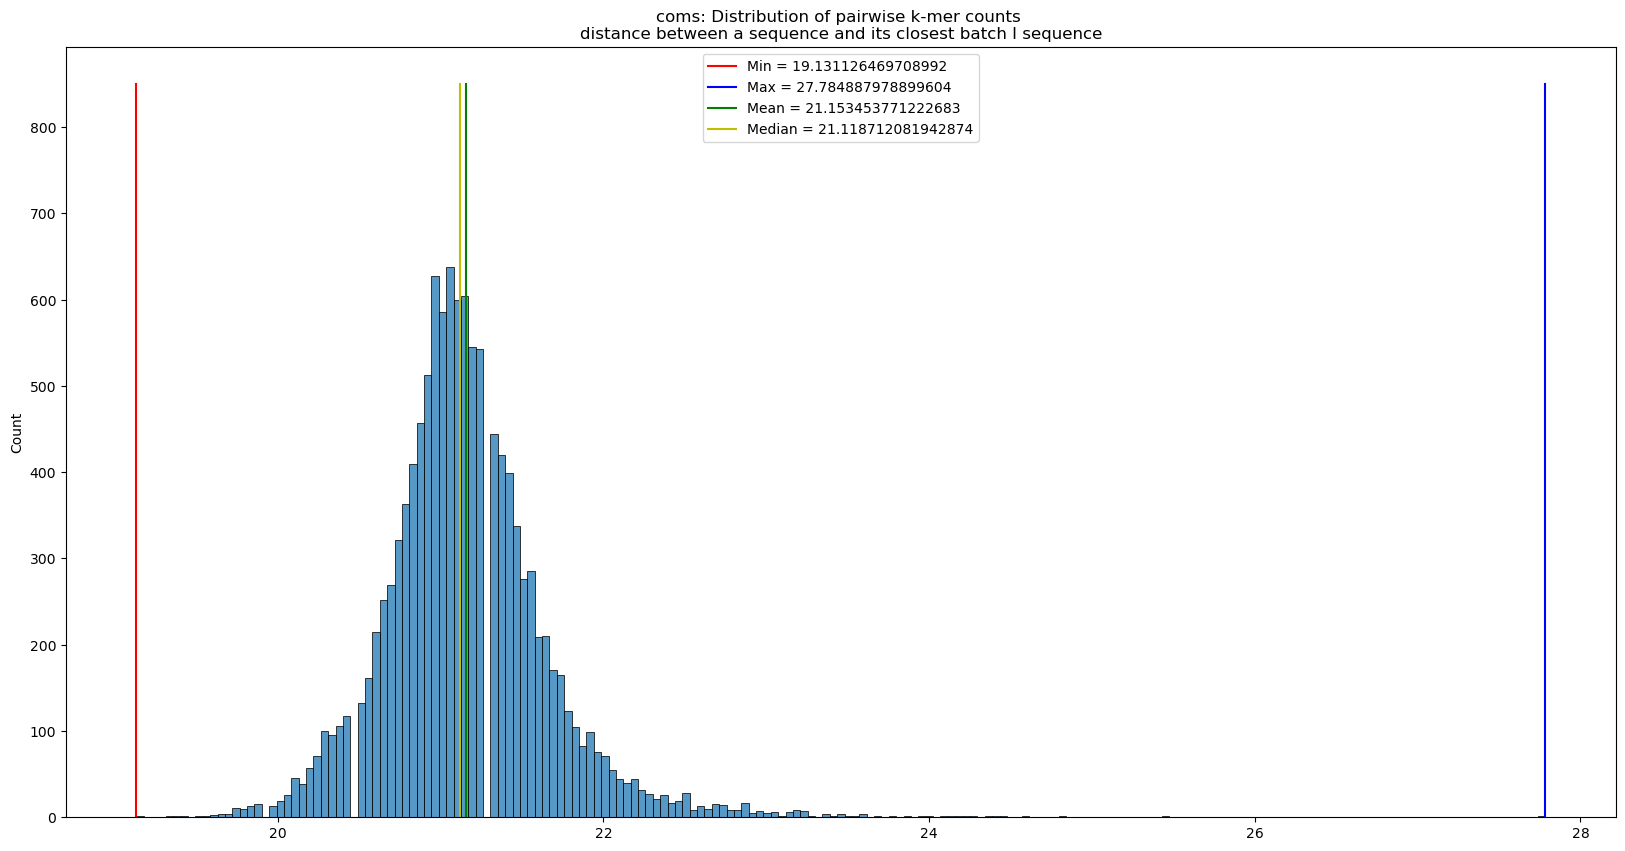

(3000,)


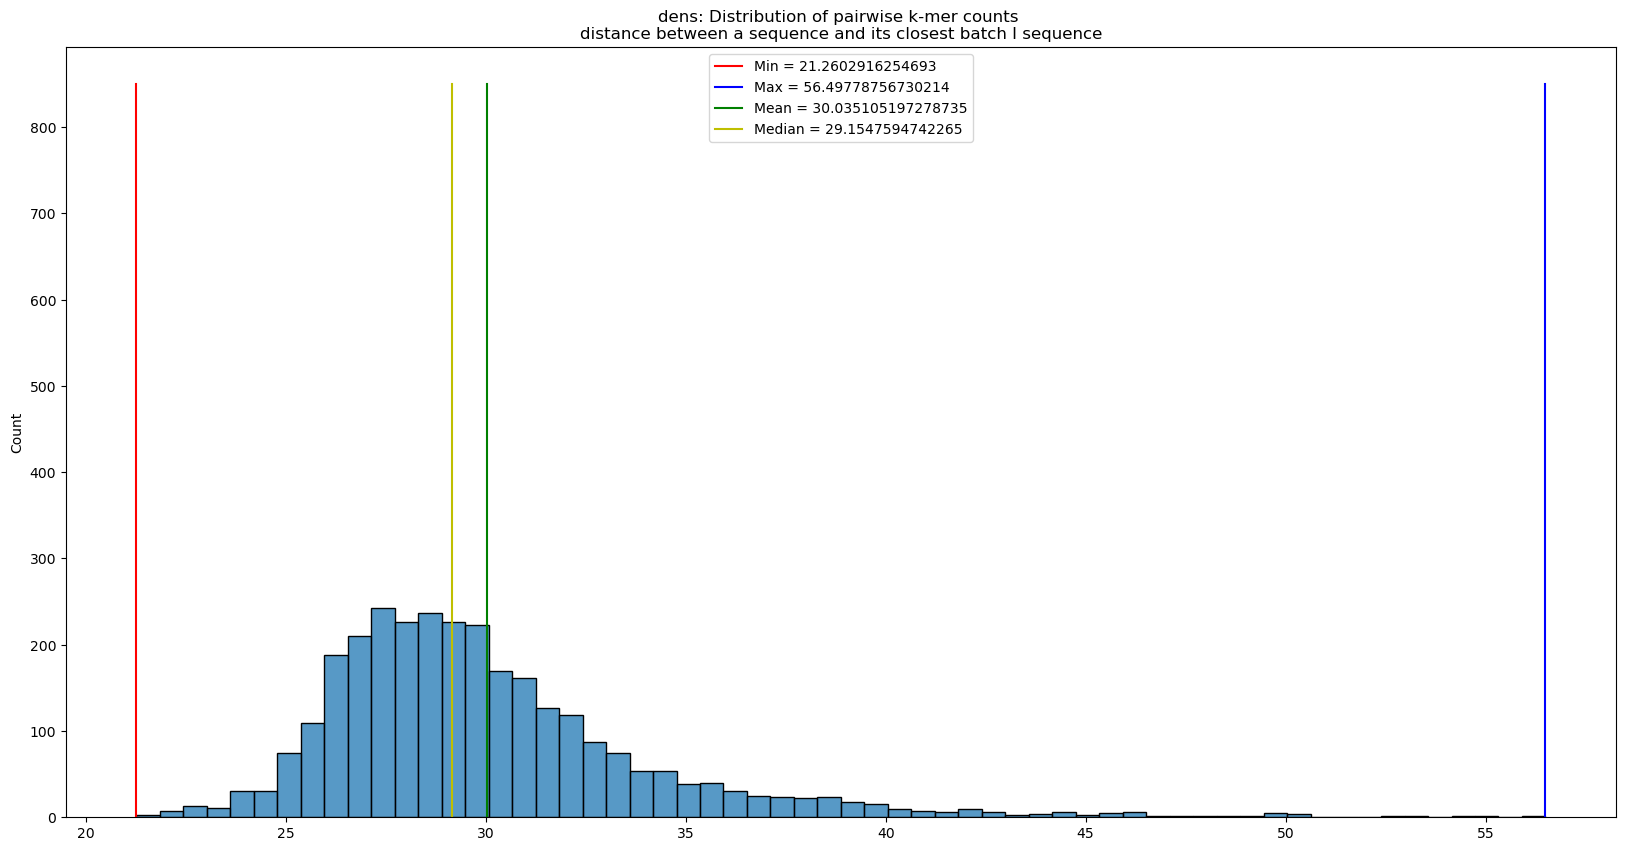

(15000,)


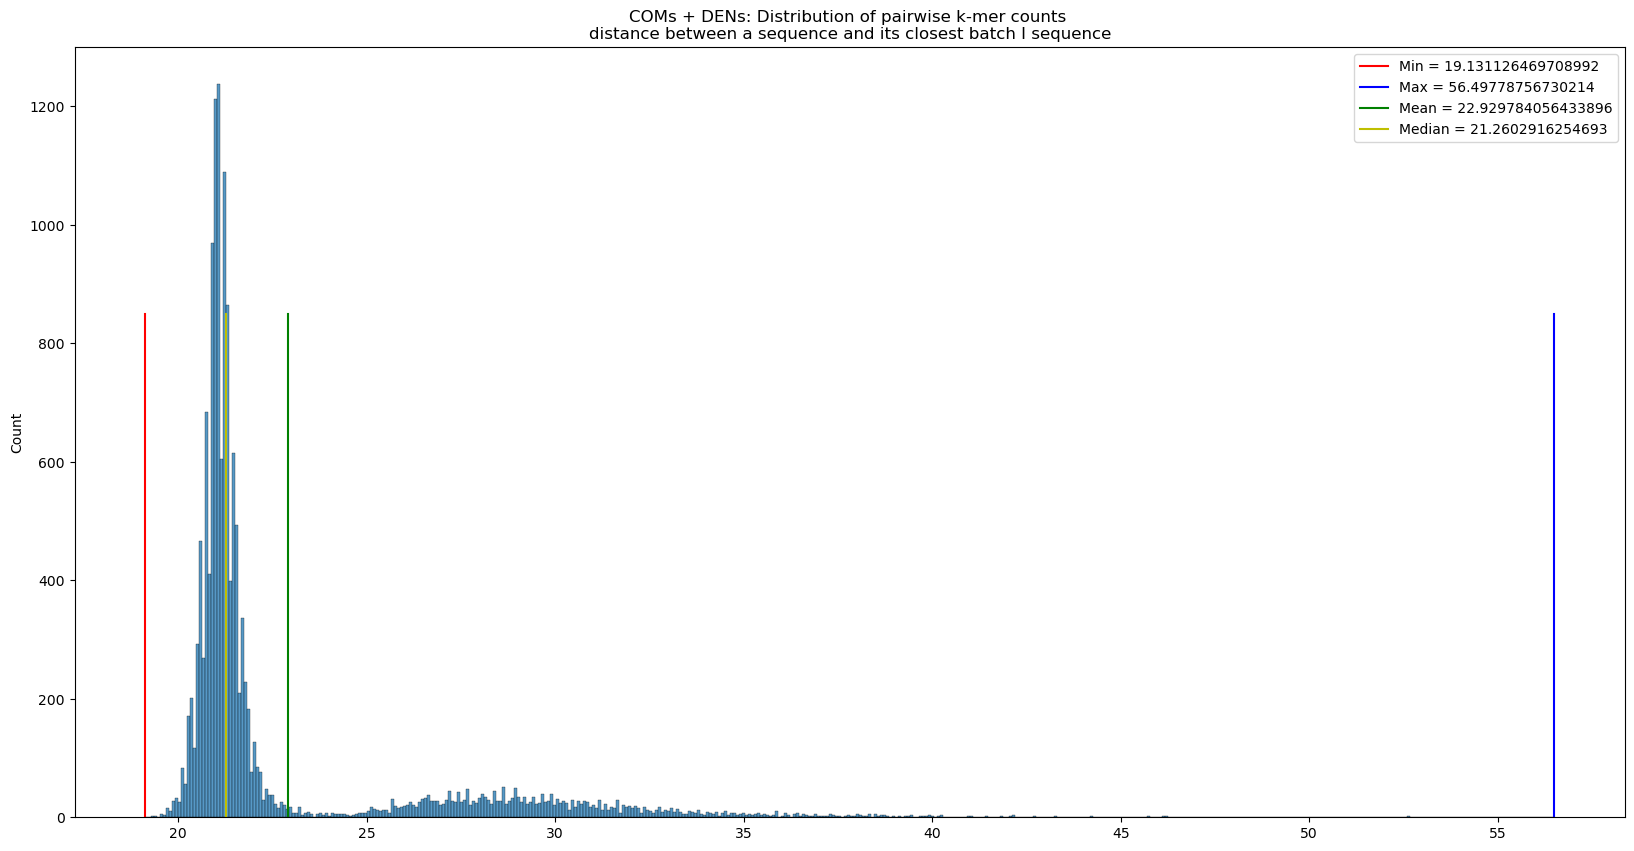

In [10]:
# get distribution of min pairwise distances for each method to batch I sequences
for method in methods + ["COMs + DENs"]:
    if method == "COMs + DENs":
        seq_inds = all_sources != "Dataset"
    else:
        seq_inds = all_sources == method
    dataset_seq_inds = all_sources == "Dataset"
    method_pairwise_dist_matrix = pairwise_distances[seq_inds][:, dataset_seq_inds]
    min_dist_to_another_seq = method_pairwise_dist_matrix.min(axis=1) * (245*np.sqrt(2))
    print(min_dist_to_another_seq.shape)
    
#     triu_inds = np.triu_indices_from(method_pairwise_dist_matrix, k=-1)
#     triu_mat = method_pairwise_dist_matrix[triu_inds]
    
    plt.figure(figsize=(20, 10))
    sns.histplot(min_dist_to_another_seq)
    plt.plot([min_dist_to_another_seq.min() for i in range(10)], np.linspace(0, 850, 10), "r-", label=f"Min = {min_dist_to_another_seq.min()}")
    plt.plot([min_dist_to_another_seq.max() for i in range(10)], np.linspace(0, 850, 10), "b-", label=f"Max = {min_dist_to_another_seq.max()}")
    plt.plot([min_dist_to_another_seq.mean() for i in range(10)], np.linspace(0, 850, 10), "g-", label=f"Mean = {min_dist_to_another_seq.mean()}")
    plt.plot([np.median(min_dist_to_another_seq) for i in range(10)], np.linspace(0, 850, 10), "y-", label=f"Median = {np.median(min_dist_to_another_seq)}")
    plt.title(f"{method}: Distribution of pairwise k-mer counts \ndistance between a sequence and its closest batch I sequence")
    plt.legend()
    plt.show()

(12000,)


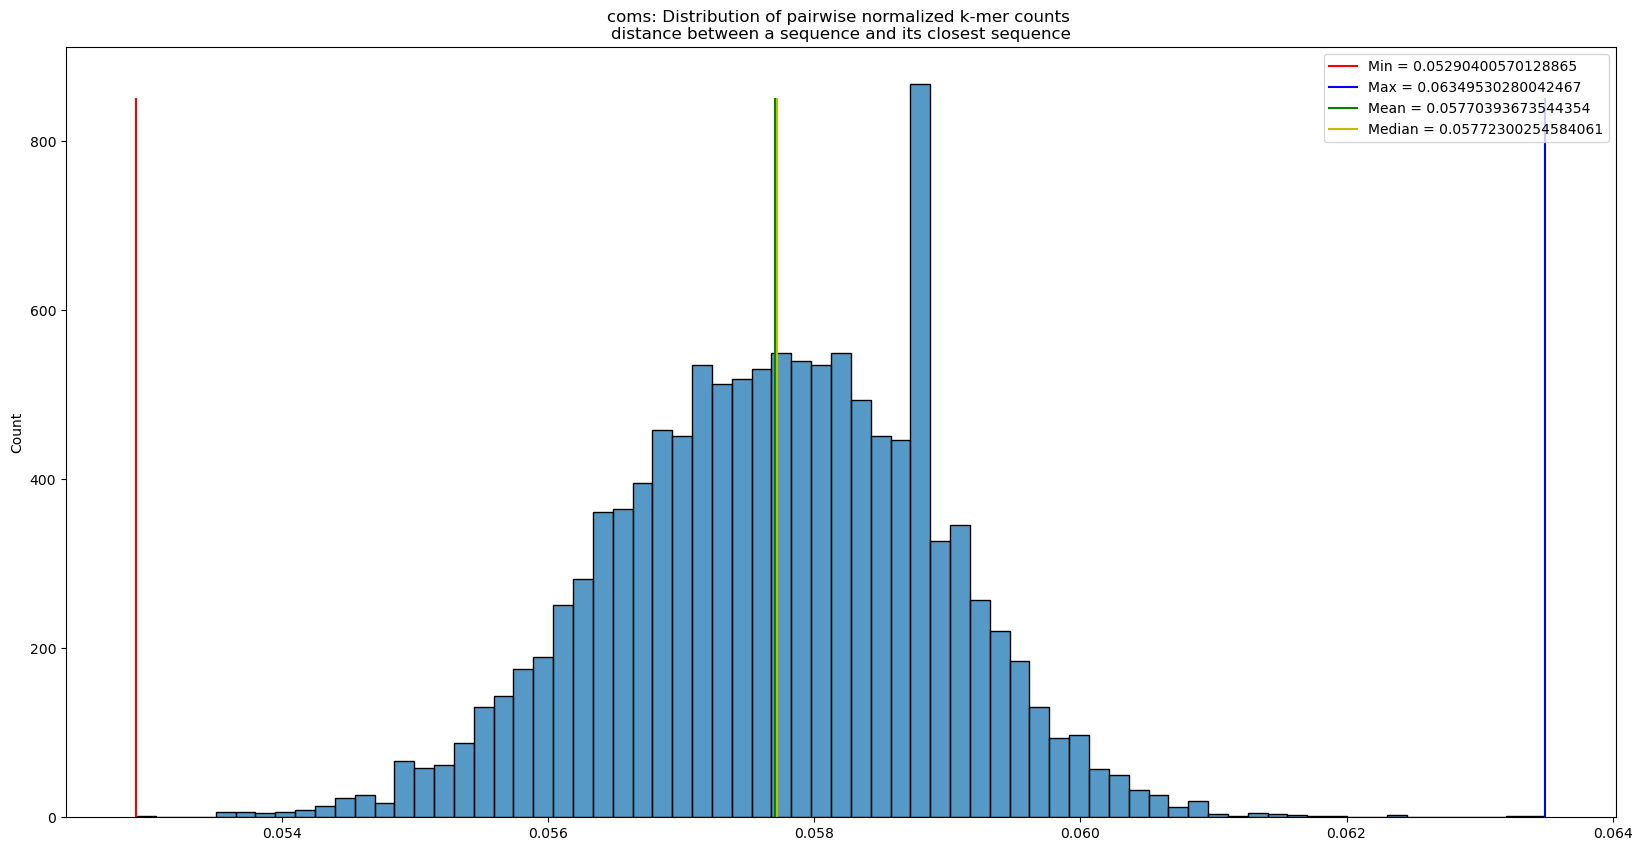

(3000,)


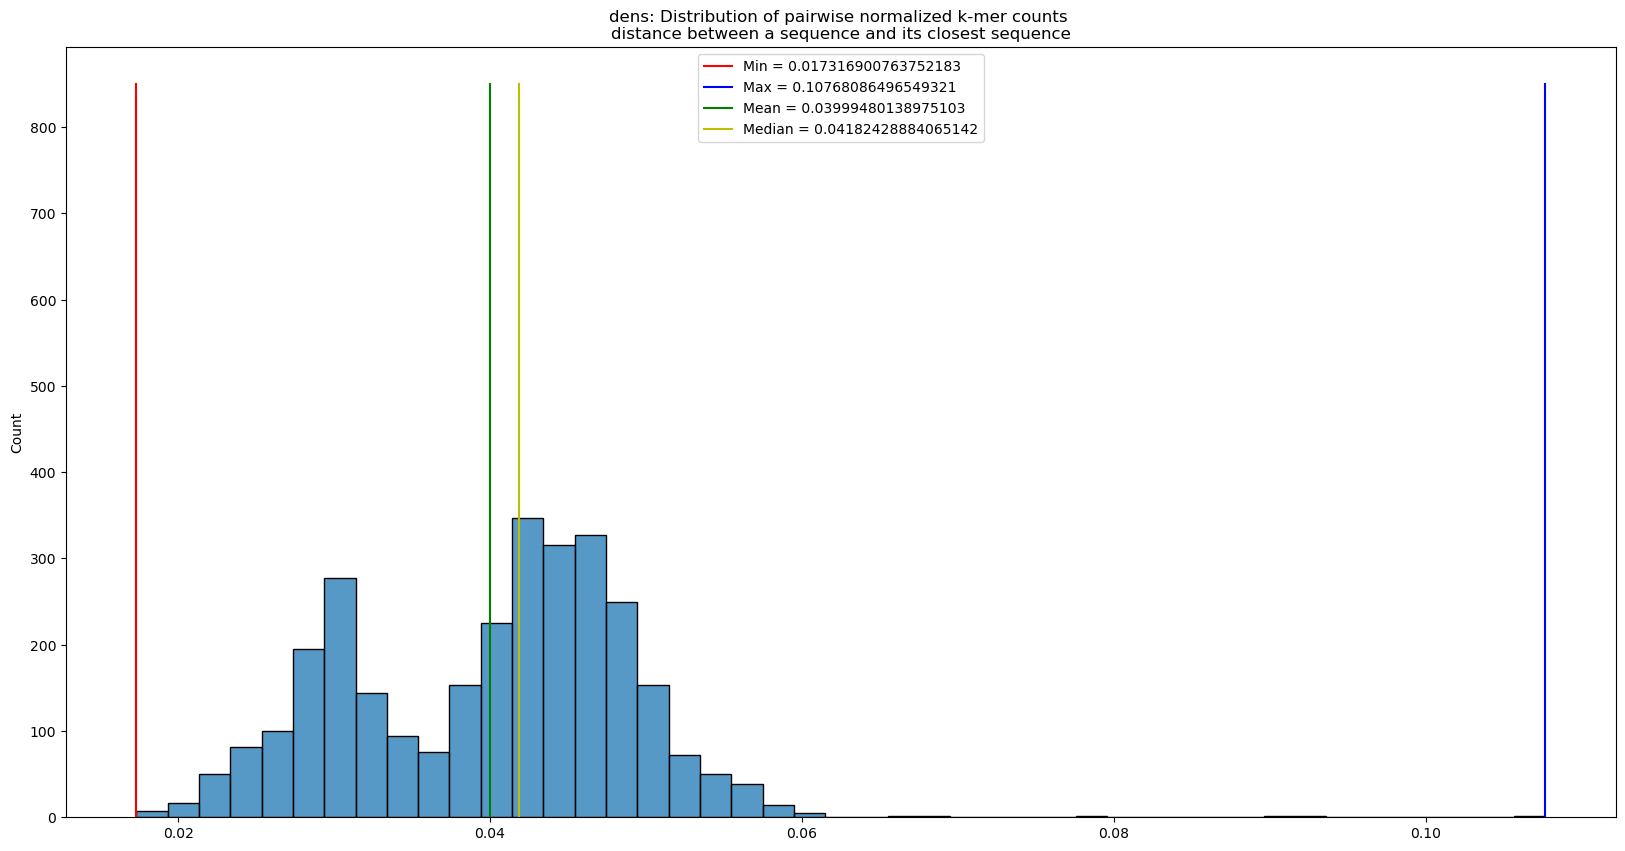

(17104,)


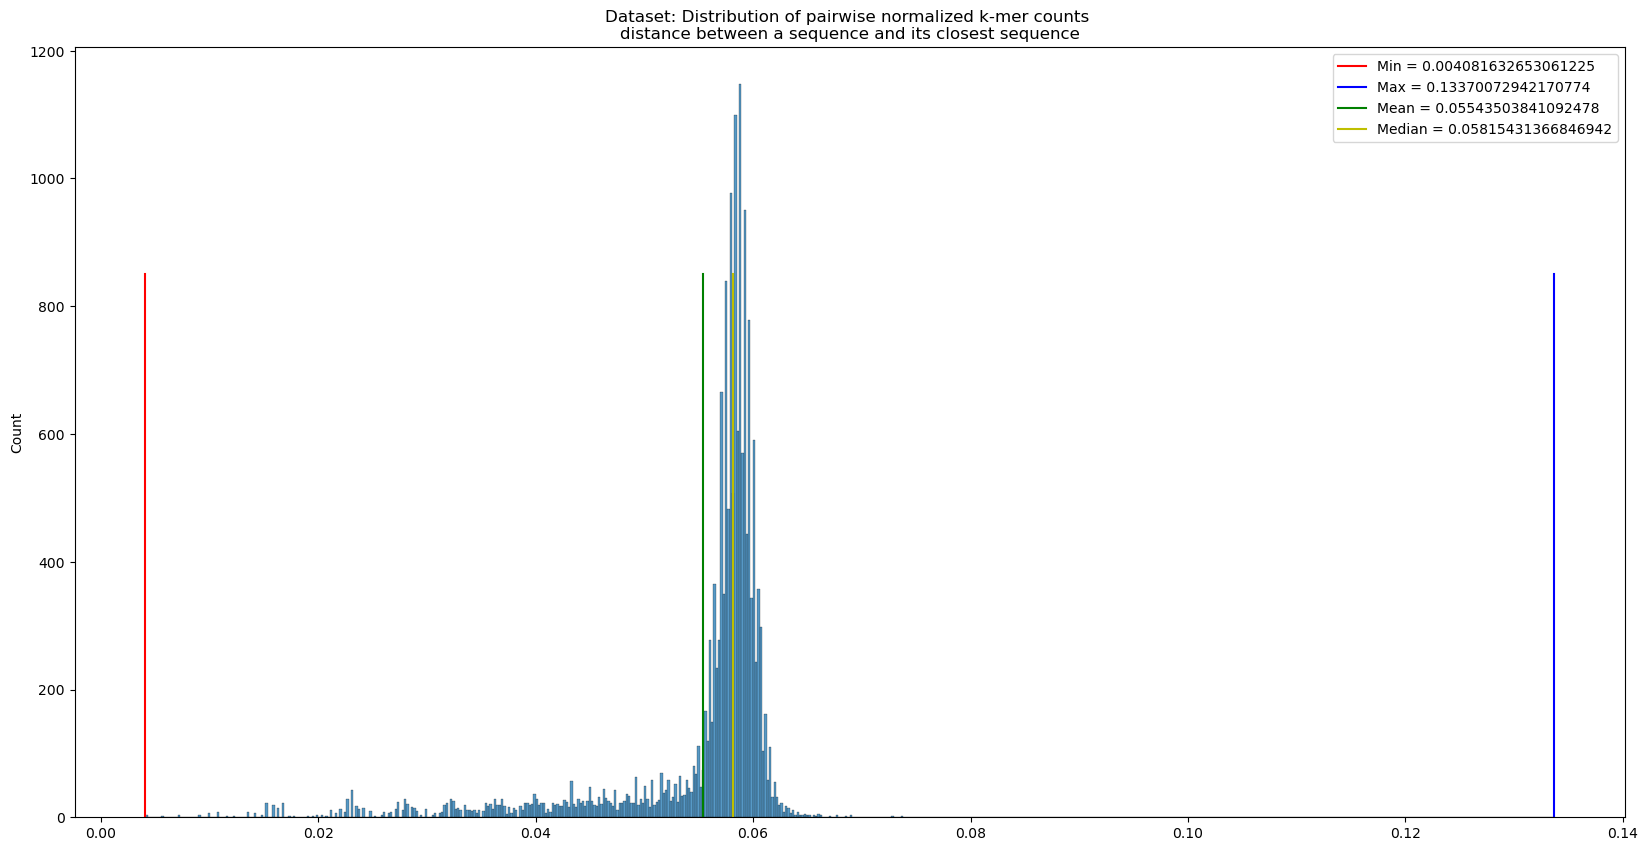

(15000,)


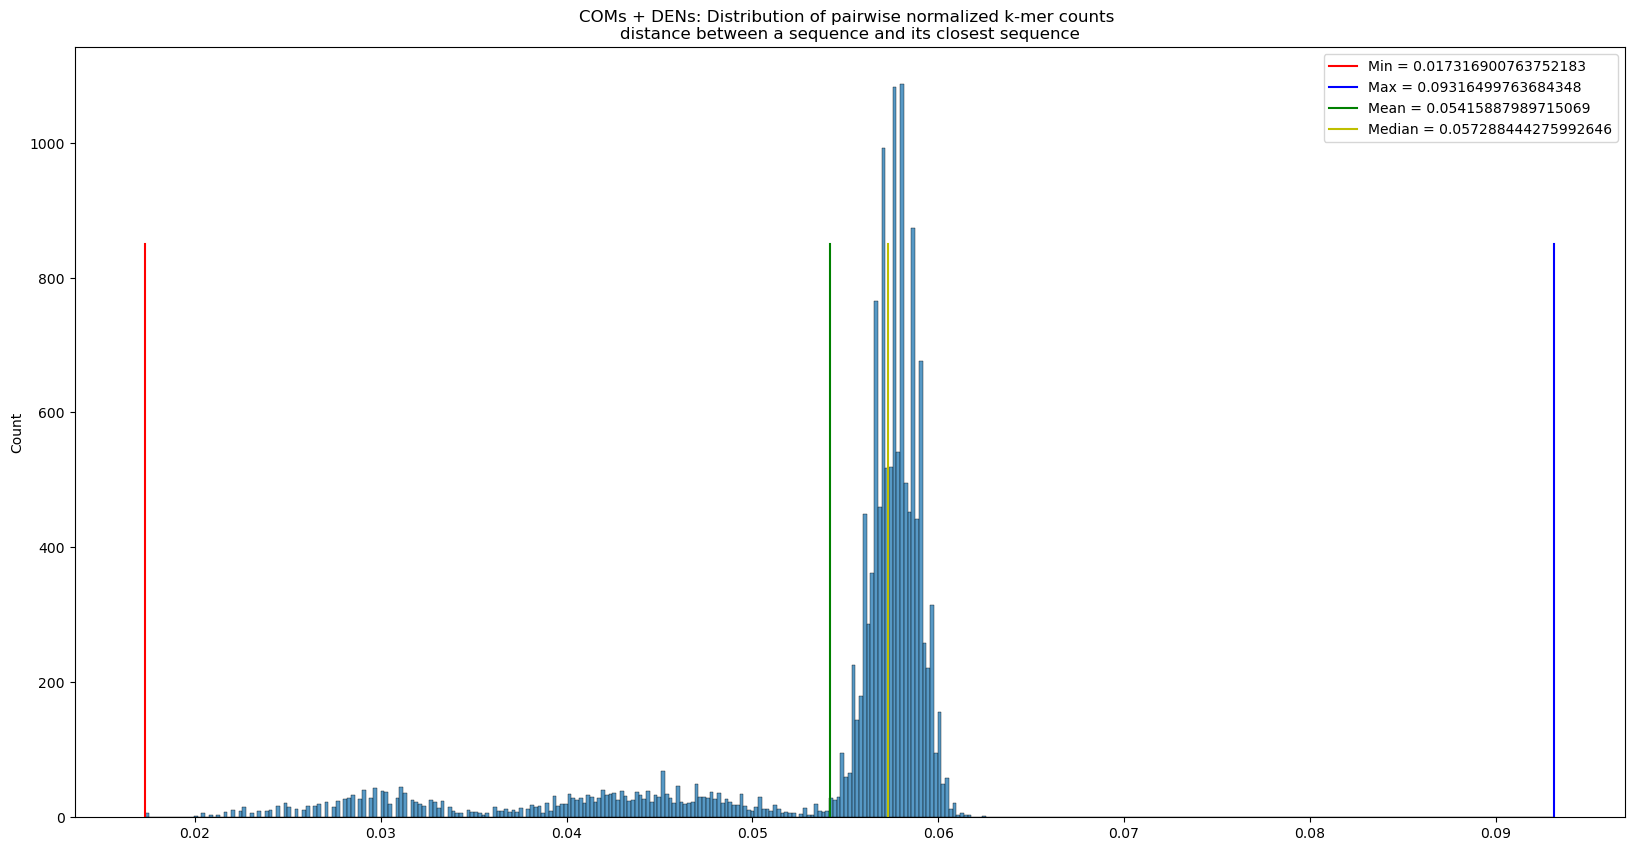

In [11]:
# get distribution of min pairwise distances for each method
for method in methods + ["Dataset", "COMs + DENs"]:
    if method == "COMs + DENs":
        seq_inds = all_sources != "Dataset"
    else:
        seq_inds = all_sources == method
    method_pairwise_dist_matrix = pairwise_distances[seq_inds][:, seq_inds]
    diag_inds = np.diag_indices_from(method_pairwise_dist_matrix)
    method_pairwise_dist_matrix[diag_inds] = np.inf
    min_dist_to_another_seq = method_pairwise_dist_matrix.min(axis=1)
    print(min_dist_to_another_seq.shape)
    
#     triu_inds = np.triu_indices_from(method_pairwise_dist_matrix, k=-1)
#     triu_mat = method_pairwise_dist_matrix[triu_inds]
    
    plt.figure(figsize=(20, 10))
    sns.histplot(min_dist_to_another_seq)
    plt.plot([min_dist_to_another_seq.min() for i in range(10)], np.linspace(0, 850, 10), "r-", label=f"Min = {min_dist_to_another_seq.min()}")
    plt.plot([min_dist_to_another_seq.max() for i in range(10)], np.linspace(0, 850, 10), "b-", label=f"Max = {min_dist_to_another_seq.max()}")
    plt.plot([min_dist_to_another_seq.mean() for i in range(10)], np.linspace(0, 850, 10), "g-", label=f"Mean = {min_dist_to_another_seq.mean()}")
    plt.plot([np.median(min_dist_to_another_seq) for i in range(10)], np.linspace(0, 850, 10), "y-", label=f"Median = {np.median(min_dist_to_another_seq)}")
    plt.title(f"{method}: Distribution of pairwise normalized k-mer counts \ndistance between a sequence and its closest sequence")
    plt.legend()
    plt.show()

(12000,)


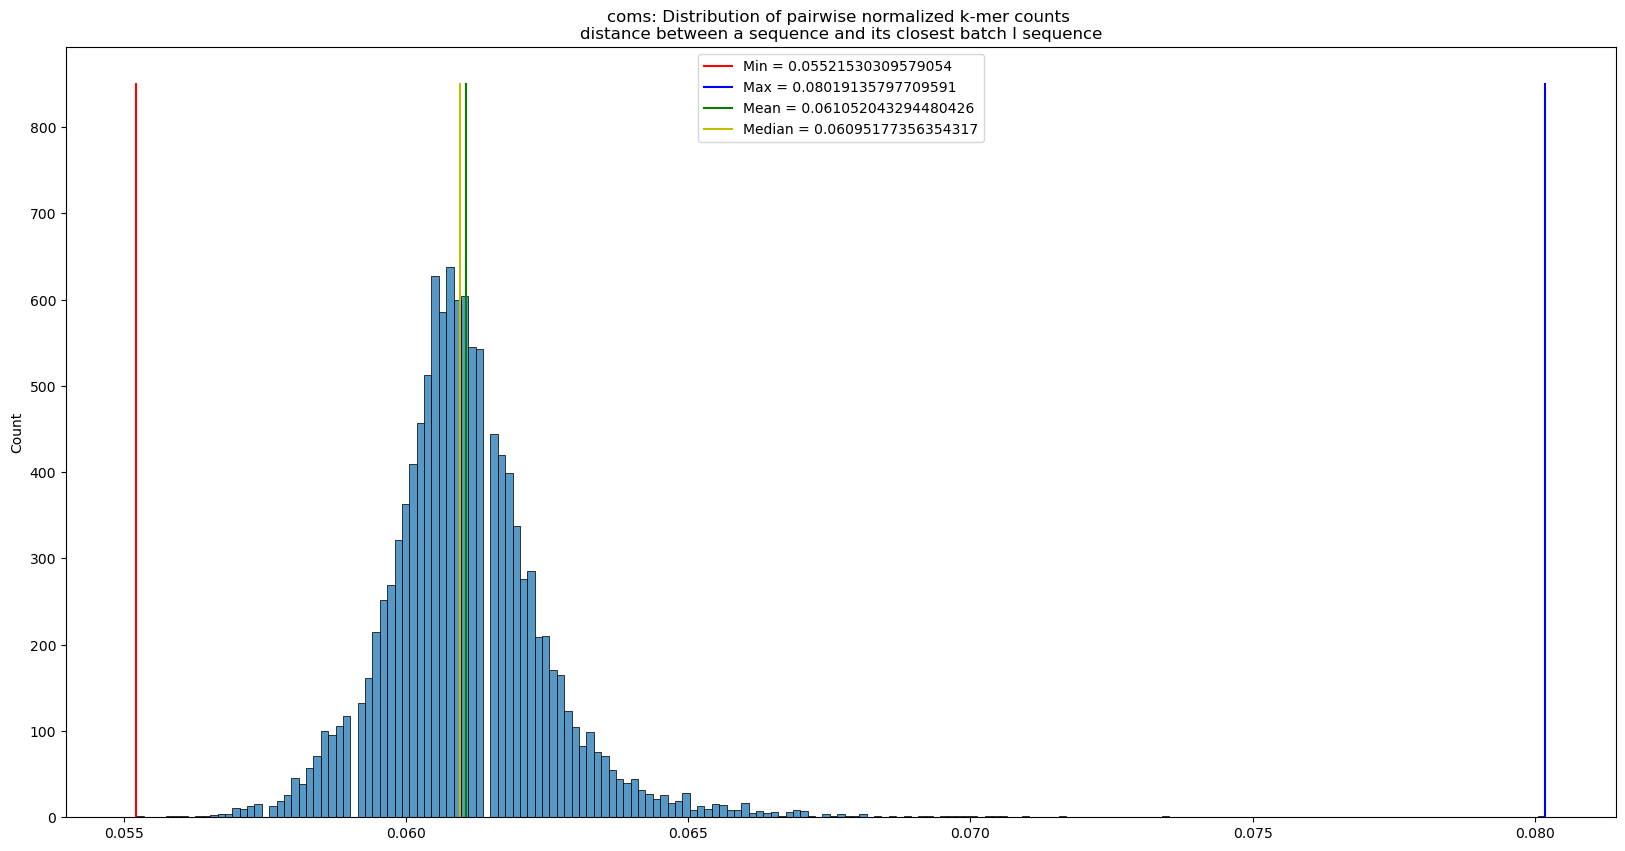

(3000,)


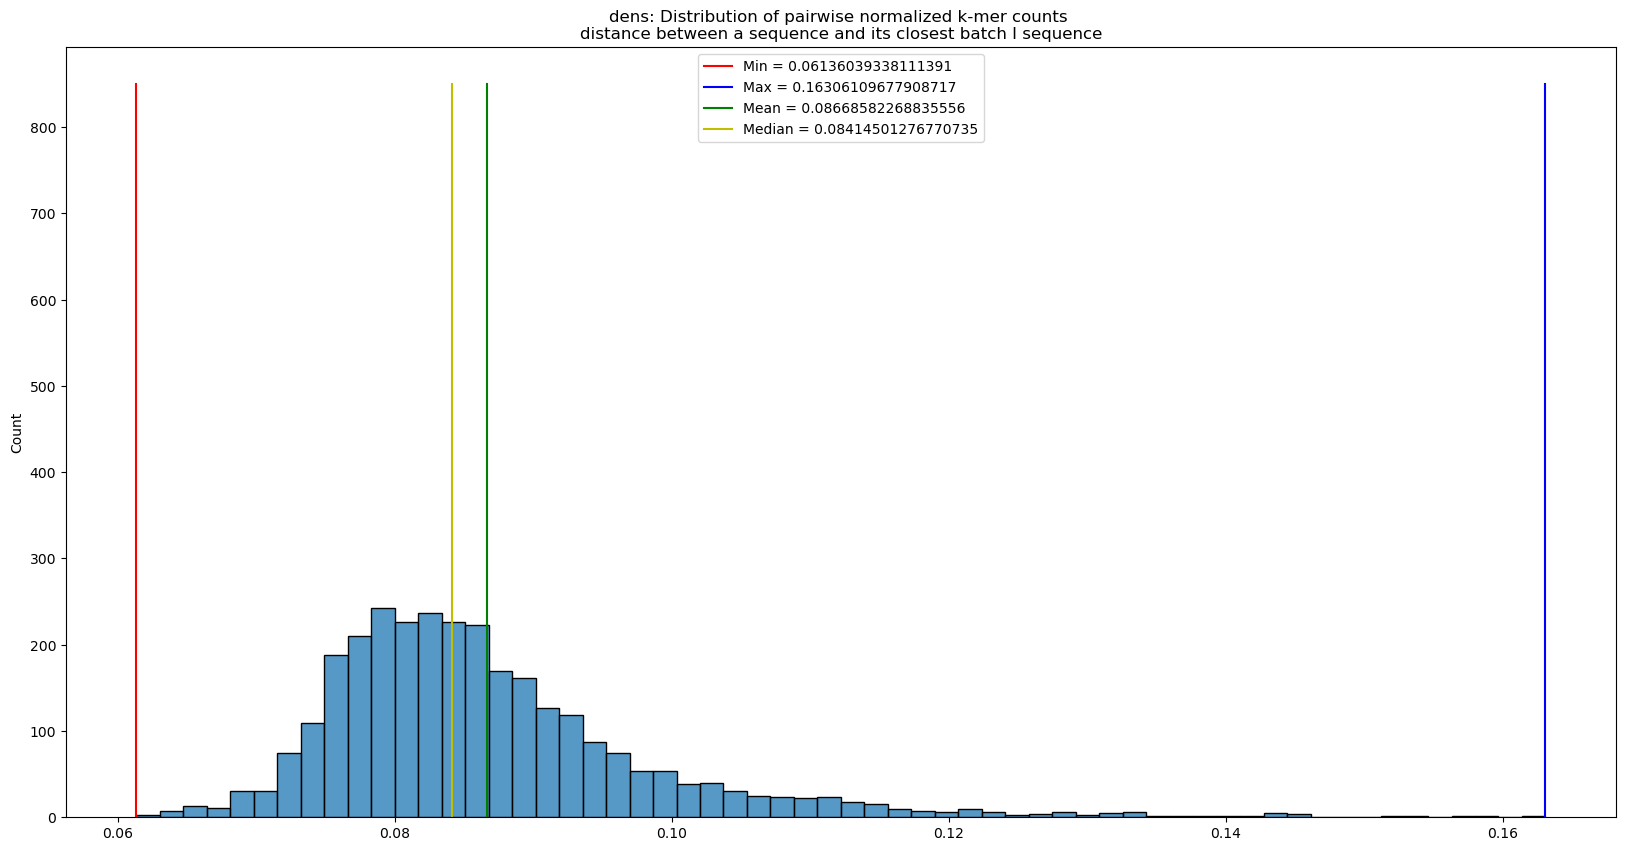

(15000,)


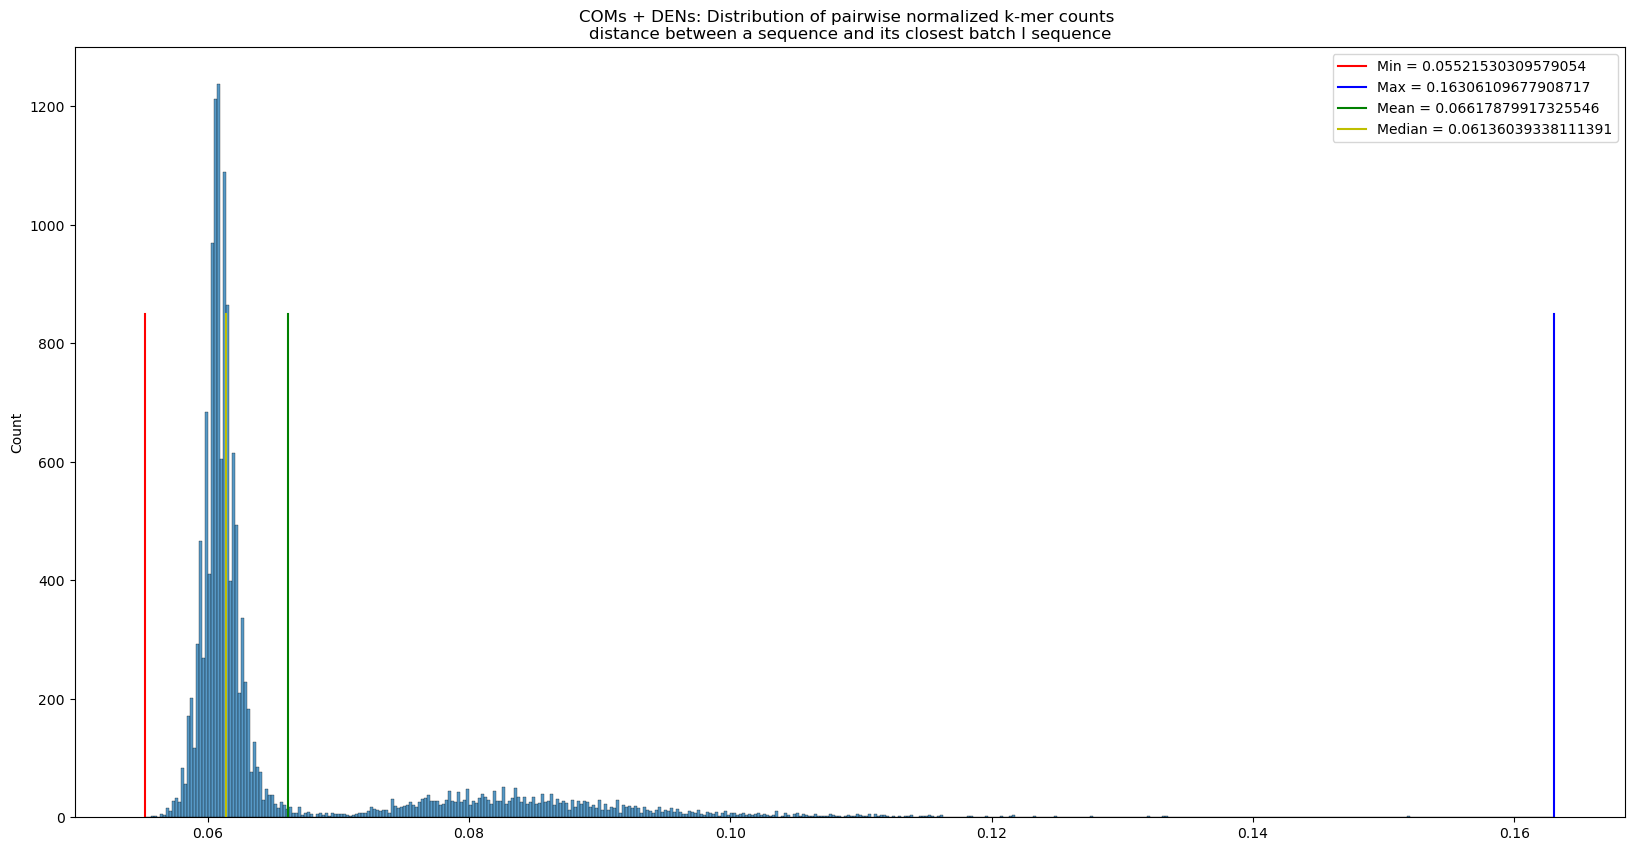

In [12]:
# get distribution of min pairwise distances for each method to batch I sequences
for method in methods + ["COMs + DENs"]:
    if method == "COMs + DENs":
        seq_inds = all_sources != "Dataset"
    else:
        seq_inds = all_sources == method
    dataset_seq_inds = all_sources == "Dataset"
    method_pairwise_dist_matrix = pairwise_distances[seq_inds][:, dataset_seq_inds]
    min_dist_to_another_seq = method_pairwise_dist_matrix.min(axis=1)
    print(min_dist_to_another_seq.shape)
    
#     triu_inds = np.triu_indices_from(method_pairwise_dist_matrix, k=-1)
#     triu_mat = method_pairwise_dist_matrix[triu_inds]
    
    plt.figure(figsize=(20, 10))
    sns.histplot(min_dist_to_another_seq)
    plt.plot([min_dist_to_another_seq.min() for i in range(10)], np.linspace(0, 850, 10), "r-", label=f"Min = {min_dist_to_another_seq.min()}")
    plt.plot([min_dist_to_another_seq.max() for i in range(10)], np.linspace(0, 850, 10), "b-", label=f"Max = {min_dist_to_another_seq.max()}")
    plt.plot([min_dist_to_another_seq.mean() for i in range(10)], np.linspace(0, 850, 10), "g-", label=f"Mean = {min_dist_to_another_seq.mean()}")
    plt.plot([np.median(min_dist_to_another_seq) for i in range(10)], np.linspace(0, 850, 10), "y-", label=f"Median = {np.median(min_dist_to_another_seq)}")
    plt.title(f"{method}: Distribution of pairwise normalized k-mer counts \ndistance between a sequence and its closest batch I sequence")
    plt.legend()
    plt.show()